In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import h5py
from glob import glob

In [12]:
# Getting our files with our images
files = glob('ESPC*fit')       # Finds list of all files in the directory using linux wildcard
files = np.array(files)
files.sort()                   # Sorts list of files

# Performing simplified aperture photometry

In [13]:
# Writing a function that will find the center of the star using a weighted average
def centroid(img_arg):
    vert_prof = np.sum(img_arg,axis=1)
    hor_prof = np.sum(img_arg,axis=0)
    y = np.sum(vert_prof*np.arange(1,vert_prof.size+1)) / np.sum(vert_prof)
    x = np.sum(hor_prof*np.arange(1,hor_prof.size+1)) / np.sum(hor_prof)
    return int(round(y)),int(round(x))

In [14]:
# Writing a function that will define the aperture and "cut out" the corresponding data within it
def cookiecutter(image,radius,center):
    cutter = np.zeros(image.shape)
    for r in xrange(radius+1):
        for t in np.arange(0,np.pi/2.0+np.pi/100.0,step=np.pi/100.0):
            y = r*np.sin(t)
            x = r*np.cos(t)
            y = int(round(y))
            x = int(round(x))
            cutter[center[0]+y,center[1]+x]=1
            cutter[center[0]+y,center[1]-x]=1
            cutter[center[0]-y,center[1]-x]=1
            cutter[center[0]-y,center[1]+x]=1
    return cutter*image

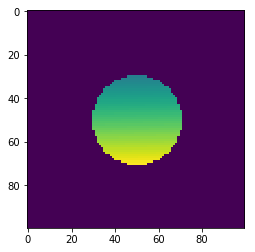

In [15]:
# Writing a test case to see if that function works
img = np.arange(10000).reshape((100,100))
rad = 20
cen = (50,50)
cutout = cookiecutter(img,rad,cen)
plt.imshow(cutout)

In [16]:
# Writing a function that will cut a box around some position in an image
def grabStar(img, center, width):
    return img[center[0]-width:center[0]+width, center[1]-width:center[1]+width]

In [17]:
# Writing a function that will perform aperture photometry on an image
def apPhot(img, loc, width, radius):
    box = grabStar(img, loc, width)
    center = centroid(box)
    cutter = cookiecutter(box, radius, center)
    
    return np.sum(cutter)

In [18]:
# Running the program for a real dataset
targetStar = (596,339)
copStar = (525,690)
Ftarget = []
Fcop = []

for f in files:
    img = fits.getdata(f)
    Ftarget.append(apPhot(img, targetStar, 25, 10))
    Fcop.append(apPhot(img, copStar, 25, 10))   

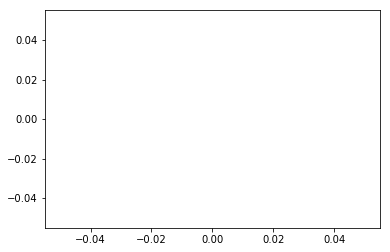

In [19]:
# Plotting our first stab at the transit
Ftarget = np.array(Ftarget)
Fcop = np.array(Fcop)

Fdiff = Ftarget-Fcop

plt.plot(Fdiff)

In [20]:
# Fitting a trend line
m,b = np.polyfit(np.arange(Fdiff.size),Fdiff,1)
plt.plot(Fdiff)
plt.plot(b+m*np.arange(Fdiff.size))

TypeError: expected non-empty vector for x

In [21]:
# Detrending
trend = b+m*np.arange(Fdiff.size)

plt.plot(Fdiff - trend, 'r.')

NameError: name 'b' is not defined